# Predicting NVIDIA and TSM Stock Price

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Input
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import time
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [3]:
def OSR2(y_train, y_test, y_pred):
    
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

# Data Cleaning, Merging, & New Variables 

In [4]:
NVDA_categ = pd.read_csv("NVDA_plus_categ.csv").rename(columns={"Adj Close": "NVDA close"})
Apple = pd.read_csv("AAPL.csv").rename(columns={"Adj Close": "Apple close"})
Nasdaq = pd.read_csv("^IXIC.csv").rename(columns={"Adj Close": "Nasdaq close"})
TSM = pd.read_csv("TSM_only_adjclose.csv").rename(columns={"Adj Close": "TSM close"})
Oil = pd.read_csv("Oil_future.csv").rename(columns={"Price": "Oil close"})
Treasury = pd.read_csv('Treaury_rate_5_years.csv').rename(columns={"Adj Close": "Treasury close"})
Bitcoin = pd.read_csv("BTC-USD data .csv").rename(columns={"Adj Close": "Bitcoin Close"})
google_trend_NVDA = pd.read_csv("googl_trend_NVDA_weekly.csv").rename(columns={"Unnamed: 1": "NVDA goog Trend"})
google_trend_TSMC = pd.read_csv("google_search_TSMC_weekly.csv").rename(columns={"TSMC_googl": "TSMC goog Trend"})
TSM_quarterly = pd.read_csv("TSM_quarterly_earnings.csv")
NVDA_quarterly = pd.read_csv("NVDA_quarterly_earnings.csv")
us_covid_cases = pd.read_csv("mod_cases.csv")

In [5]:
combined = NVDA_categ.merge(Apple, on = 'Date').merge(Nasdaq, on = 'Date').merge(TSM, on = 'Date').merge(Oil, on = 'Date').merge(Treasury, on = 'Date').merge(Bitcoin, on = 'Date').merge(google_trend_NVDA, on = "Date").merge(google_trend_TSMC, on = 'Date').merge(TSM_quarterly, on = 'Date').merge(NVDA_quarterly, on = "Date")
combined = combined.rename(columns={'Earnings ': 'NVIDIA quarterly earnings'})
combined['DateTime'] = pd.to_datetime(combined['Date'], infer_datetime_format=True)
combined['Month'] = combined['DateTime'].dt.month_name()
combined['DayWeek'] = combined['DateTime'].dt.day_name()
combined['NVDA5day'] = combined['NVDA close'].shift(5)
combined['NVDA10day'] = combined['NVDA close'].shift(10)
combined['TSM5day'] = combined['TSM close'].shift(5)
combined['TSM10day'] = combined['TSM close'].shift(10)
combined['TSMpred'] = combined['TSM close'].shift(-1)
combined['NVDApred'] = combined['NVDA close'].shift(-1)
combined.fillna(0, inplace=True)
combined.drop(index=combined.index[-1],axis=0,inplace=True)


# Train-Test Split & Encoding

In [6]:
train = combined[combined['DateTime'].dt.year <= 2021] #toDo
test = combined[combined['DateTime'].dt.year > 2021] #toDo
test.set_index('DateTime',  inplace=True)
train.set_index('DateTime',  inplace=True)
train_nodate = train.drop(columns=['Date'])
test_nodate = test.drop(columns=['Date'])
train_encode = pd.get_dummies(train_nodate, drop_first = True)
test_encode = pd.get_dummies(test_nodate, drop_first = True)
#random.sample()

In [7]:
X_train_NVDA = train_encode.drop(columns=['NVDA close', 'TSMC goog Trend',
'TSM quarter earnings','TSM5day', 'TSM10day','Month_December','NVDApred'])
y_train_NVDA = train_encode['NVDApred']
X_test_NVDA = test_encode.drop(columns=['NVDA close', 'TSMC goog Trend',
'TSM quarter earnings','TSM5day', 'TSM10day','NVDApred'])
y_test_NVDA = test_encode['NVDApred']
X_train_TSM = train_encode.drop(columns=['NVIDIA 2000 release','NVIDIA 3000 release', 'NVIDIA 4000 release','NVDA goog Trend',
'NVIDIA quarterly earnings','NVDA5day', 'NVDA10day','TSM close','Month_December','TSMpred',])
y_train_TSM = train_encode['TSMpred']
X_test_TSM = test_encode.drop(columns=['NVIDIA 2000 release','NVIDIA 3000 release', 'NVIDIA 4000 release','NVDA goog Trend',
'NVIDIA quarterly earnings','NVDA5day', 'NVDA10day','TSM close','TSMpred'])
y_test_TSM = test_encode['TSMpred']

## Baseline model

In [11]:
#We use the price from 5 days ago to predict future prices as baseline
base_NVDA_pred = X_train_NVDA['NVDA5day']
base_TSM_pred = X_train_TSM['TSM5day']
base_NVDA_pred_test = X_test_NVDA['NVDA5day']
base_TSM_pred_test = X_test_TSM['TSM5day']
NVDA_base_R2 = round(r2_score(y_train_NVDA, base_NVDA_pred),5)
TSM_base_R2 = round(r2_score(y_train_TSM, base_TSM_pred),5)
NVDA_base_OSR2 = round(r2_score(y_test_NVDA, base_NVDA_pred_test),5)
TSM_base_OSR2 =round(r2_score(y_test_TSM, base_TSM_pred_test),5)
#print(NVDA_base_R2,TSM_base_R2,NVDA_base_OSR2,TSM_base_OSR2)
TSM_b_PER,TSM_b_ALPER, TSM_b_RATIO = stocktradesimulator(y_test_TSM, base_TSM_pred_test)
NVDA_b_PER,NVDA_b_ALPER, NVDA_b_RATIO = stocktradesimulator(y_test_NVDA, base_NVDA_pred_test)

## Logistic Model

In [12]:
train_special_x = train_encode.copy()
train_special_x 

,NVDA close,Biden,Covid (no vax),First Vax,Booster,Ukraine,Pelosi is Speaker,NVIDIA 2000 release,NVIDIA 3000 release,NVIDIA 4000 release,...,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,DayWeek_Monday,DayWeek_Thursday,DayWeek_Tuesday,DayWeek_Wednesday
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-02-15,61.003242,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2018-02-16,60.344952,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-02-20,61.641731,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2018-02-21,59.768330,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2018-02-22,59.963951,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,309.160919,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2021-12-28,302.936707,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2021-12-29,299.729736,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<AxesSubplot: >

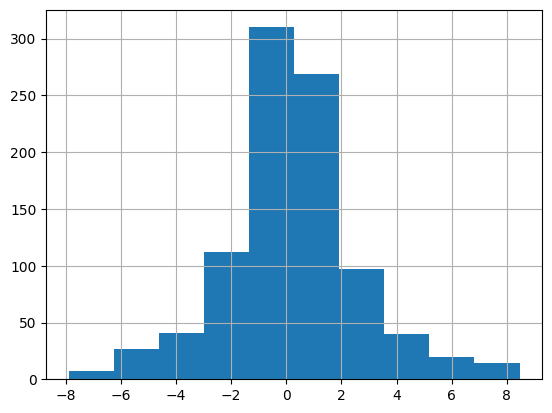

In [13]:
(train_special_x['NVDA close'] - train_special_x['NVDA close'].shift(1)).sort_values()[20:-20].hist()

In [14]:
std_x = (train_special_x['NVDA close'] - train_special_x['NVDA close'].shift(1)).sort_values()[20:-20].std()
std_x
#Use 0.4 Z to get 15% coverage on each side of mean (30% total)

2.414275618943914

In [15]:
std_mean = (train_special_x['NVDA close'] - train_special_x['NVDA close'].shift(1)).sort_values()[20:-20].mean()

In [16]:
z_val = 1
day_change = (train_special_x['NVDA close'] - train_special_x['NVDA close'].shift(1))
train_special_x['day_change'] = day_change
train_special_x = train_special_x[1:]
train_special_x
train_special_y = pd.DataFrame()
y_list = []
for i in train_special_x['day_change']:
    if i <= (std_mean + std_x * -z_val):
        y_list.append(0)
    elif i >= (std_mean + std_x * z_val):
        y_list.append(2)
    else:
        y_list.append(1)
train_special_y['Y'] = y_list

In [17]:
train_special_x = train_special_x.drop(columns=['NVDA close', 'TSMC goog Trend','TSM quarter earnings','TSM5day', 'TSM10day', 'day_change'])

In [18]:
test_special_x = test_encode.copy()

day_change_1 = (test_special_x['NVDA close'] - test_special_x['NVDA close'].shift(1))
test_special_x['day_change'] = day_change_1
test_special_x = test_special_x[1:]
test_special_x
test_special_y = pd.DataFrame()
y_list_1 = []
for i in test_special_x['day_change']:
    if i <= (std_mean + std_x * -z_val):
        y_list_1.append(0)
    elif i >= (std_mean + std_x * z_val):
        y_list_1.append(2)
    else:
        y_list_1.append(1)
test_special_y['Y'] = y_list_1

test_special_x = test_special_x.drop(columns=['NVDA close', 'TSMC goog Trend','TSM quarter earnings','TSM5day', 'TSM10day', 'day_change'])

In [19]:
test_special_x['Month_December'] = 0

In [20]:
test_special_x = test_special_x.reindex(sorted(test_special_x.columns), axis=1)
train_special_x = train_special_x.reindex(sorted(train_special_x.columns), axis=1)

In [21]:
train_np_x = train_special_x.to_numpy()
test_np_x = test_special_x.to_numpy()
train_np_y = train_special_y.to_numpy()
test_np_y = test_special_y.to_numpy()

In [22]:
flat_list = [item for sublist in test_np_y for item in sublist]
test_np_y_array = np.array(flat_list)
#test_np_y_array


In [23]:
flat_list = [item for sublist in train_np_y for item in sublist]
train_np_y_array = np.array(flat_list)
#train_np_y_array

In [24]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax
onehot_encoder = OneHotEncoder(sparse=False)

def loss(X, Y, W):
    """
    Y: onehot encoded
    """
    Z = - X @ W
    N = X.shape[0]
    loss = 1/N * (np.trace(X @ W @ Y.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))
    return loss

def gradient(X, Y, W, mu):
    """
    Y: onehot encoded 
    """
    Z = - X @ W
    P = softmax(Z, axis=1)
    N = X.shape[0]
    gd = 1/N * (X.T @ (Y - P)) + 2 * mu * W
    return gd

def gradient_descent(X, Y, max_iter=1000, eta=0.1, mu=0.01):
    """
    Very basic gradient descent algorithm with fixed eta and mu
    """
    Y_onehot = onehot_encoder.fit_transform(Y.reshape(-1,1))
    W = np.zeros((X.shape[1], Y_onehot.shape[1]))
    step = 0
    step_lst = [] 
    loss_lst = []
    W_lst = []
 
    while step < max_iter:
        step += 1
        W -= eta * gradient(X, Y_onehot, W, mu)
        step_lst.append(step)
        W_lst.append(W)
        loss_lst.append(loss(X, Y_onehot, W))

    df = pd.DataFrame({
        'step': step_lst, 
        'loss': loss_lst
    })
    return df, W

class Multiclass:
    def fit(self, X, Y):
        self.loss_steps, self.W = gradient_descent(X, Y)

    def loss_plot(self):
        return self.loss_steps.plot(
            x='step', 
            y='loss',
            xlabel='step',
            ylabel='loss'
        )

    def predict(self, H):
        Z = - H @ self.W
        P = softmax(Z, axis=1)
        return np.argmax(P, axis=1)
    
X = train_np_x
Y = train_np_y_array


model = Multiclass()
model.fit(X, Y)

/tmp/ipykernel_80/1008045572.py:12: RuntimeWarning: overflow encountered in exp
  loss = 1/N * (np.trace(X @ W @ Y.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))


In [25]:
# predict 
model.predict(X)

# check the predicted value and the actual value
(model.predict(X) == Y).sum() / len(model.predict(X) == Y)

0.7284836065573771

In [26]:
model.predict(test_np_x)
# check the predicted value and the actual value
(model.predict(test_np_x) == test_np_y_array).sum() / len(model.predict(test_np_x) == test_np_y_array)

0.25

In [28]:
import statsmodels.formula.api as smf

In [29]:
train_bin_log_x = train_encode.copy()
test_bin_log_x = test_encode.copy()

In [30]:
z_val = 0.3
day_change = (train_bin_log_x['NVDA close'] - train_bin_log_x['NVDA close'].shift(1))
train_bin_log_x['day_change'] = day_change
train_bin_log_x = train_bin_log_x[1:]
train_bin_log_x
train_bin_log_y = pd.DataFrame()
y_list = []
for i in train_bin_log_x['day_change']:
    if i < (std_mean):# + (std_x * z_val)):
        y_list.append(0)
    else:
        y_list.append(1)
train_bin_log_y['Y'] = y_list

In [31]:
train_bin_log_x = train_bin_log_x.drop(columns=['NVDA close', 'TSMC goog Trend','TSM quarter earnings','TSM5day', 'TSM10day', 'day_change'])

In [32]:
day_change = (test_bin_log_x['NVDA close'] - test_bin_log_x['NVDA close'].shift(1))
test_bin_log_x['day_change'] = day_change
test_bin_log_x = test_bin_log_x[1:]
test_bin_log_x
test_bin_log_y = pd.DataFrame()
y_list_1 = []
for i in test_bin_log_x['day_change']:
    if i < (std_mean):# + (std_x * z_val)):
        y_list_1.append(0)
    else:
        y_list_1.append(1)
test_bin_log_y['Y'] = y_list_1

test_bin_log_x = test_bin_log_x.drop(columns=['NVDA close', 'TSMC goog Trend','TSM quarter earnings','TSM5day', 'TSM10day', 'day_change'])

In [33]:
test_bin_log_x['Month_December'] = 0

In [34]:
test_bin_log_x = test_bin_log_x.reindex(sorted(test_bin_log_x.columns), axis=1)
train_bin_log_x = train_bin_log_x.reindex(sorted(train_bin_log_x.columns), axis=1)

In [35]:
train_bin_log_x['Y'] = train_bin_log_y['Y'].tolist()
test_bin_log_x['Y'] = test_bin_log_y['Y'].tolist()

In [36]:
tempcolumn = []
for item in train_bin_log_x.columns:
    item = item.replace(' ','_')
    tempcolumn.append(item.replace('Covid_(no_vax)','Covid_no_vax'))

In [37]:
train_bin_log_x.columns = tempcolumn
test_bin_log_x.columns = tempcolumn

In [38]:
# Iteratively write formula
formula = "Y ~"
for col in train_bin_log_x.columns[:]:
    formula += f" {col} +"
formula = formula[:-2]

In [39]:
train_bin_log_x

,Apple_close,Biden,Bitcoin_Close,Booster,Covid_no_vax,DayWeek_Monday,DayWeek_Thursday,DayWeek_Tuesday,DayWeek_Wednesday,First_Vax,...,NVIDIA_4000_release,NVIDIA_quarterly_earnings,Nasdaq_close,Oil_close,Pelosi_is_Speaker,TSM_close,TSMpred,Treasury_close,Ukraine,Y
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-02-16,41.158035,0,10233.90039,0,0,0,0,0,0,0,...,0,0.395,7239.470215,61.68,0,37.806274,38.032345,2.626,0,0
2018-02-20,41.019585,0,11403.70020,0,0,0,0,1,0,0,...,0,0.395,7234.310059,61.90,0,38.032345,37.293262,2.648,0,1
2018-02-21,40.833408,0,10690.40039,0,0,0,0,0,1,0,...,0,0.395,7218.229980,61.68,0,37.293262,36.858505,2.679,0,0
2018-02-22,41.174744,0,10005.00000,0,0,0,1,0,0,0,...,0,0.395,7210.089844,62.77,0,36.858505,38.171467,2.652,0,0
2018-02-23,41.890827,0,10301.09961,0,0,0,0,0,0,0,...,0,0.395,7337.390137,63.55,0,38.171467,38.614910,2.618,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,179.289459,1,50640.41797,1,0,1,0,0,0,0,...,0,1.170,15871.259770,75.57,1,120.788139,120.158104,1.252,0,1
2021-12-28,178.255447,1,47588.85547,1,0,0,0,1,0,0,...,0,1.170,15781.719730,75.98,1,120.158104,119.518242,1.245,0,0
2021-12-29,178.344925,1,46444.71094,1,0,0,0,0,1,0,...,0,1.170,15766.219730,76.56,1,119.518242,118.543663,1.294,0,0


In [40]:
#log_reg = smf.logit(formula = formula, data = train_bin_log_x).fit()

In [41]:
def stocktradesimulator(actualclose, predictedclose):
    cash = 100
    actualperformance = actualclose[-1]/actualclose[0]
    stock = cash/actualclose[0]
    cash = 0
    for i in range(1, len(predictedclose)-1):
        if predictedclose[i] >= actualclose[i-1] and cash != 0:
            stock = cash/actualclose[i-1]
            cash = 0
        if predictedclose[i] < actualclose[i-1] and stock != 0:
            cash = stock * actualclose[i-1]
            stock = 0
    if stock != 0:
        cash = stock * actualclose[i-1]
        stock = 0
    algoperformance = cash/100
    ratio = (algoperformance - actualperformance) / actualperformance
    return(round(actualperformance, 5), round(algoperformance, 5), round(ratio,5))

#  Random Forest Model

In [42]:
## using GridSearchCV to find best max_features:
## Code from lab 8a
# NVDA Regression
import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

grid_values = {'max_features': np.linspace(1,18,18, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 

tic = time.time()

rf = RandomForestRegressor() 
# Note: here we set verbose=2 to keep track of the progress (the running time) of the cross validation. 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv = GridSearchCV(rf, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv.fit(X_train_NVDA, y_train_NVDA)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.8s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_e

In [43]:
print(rf_cv.best_params_)

{'max_features': 14, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88}


In [44]:
def OSR2_b(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

print('Cross-validated R2:', round(rf_cv.best_score_, 5))
print('OSR2:', round(OSR2_b(rf_cv, X_test_NVDA, y_test_NVDA, y_train_NVDA), 5))

Cross-validated R2: 0.99621
OSR2: 0.95547


In [45]:
#Skeleton Code from lab8 
#Using parameters found using grid search
import time
tic = time.time()

rf = RandomForestRegressor(max_features=15, min_samples_leaf=5, 
                           n_estimators = 500, random_state=88, verbose=2) 

rf.fit(X_train_NVDA, y_train_NVDA)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building

In [46]:
rf.verbose = False

print('OSR2:', round(OSR2_b(rf, X_test_NVDA, y_test_NVDA, y_train_NVDA), 5))

OSR2: 0.95469


In [47]:
y_pred_sp = rf.predict(X_test_NVDA)

In [48]:
NVDA_RF_PER,NVDA_RF_ALPER, NVDA_RF_RATIO = stocktradesimulator(y_test_NVDA, y_pred_sp)

In [49]:
pd.DataFrame({'Feature' : X_train_NVDA.columns, 
              'Importance score': 100*rf.feature_importances_}).round(1)

,Feature,Importance score
0,Biden,0.1
1,Covid (no vax),0.1
2,First Vax,0.8
3,Booster,1.6
4,Ukraine,0.0
5,Pelosi is Speaker,0.0
6,NVIDIA 2000 release,0.0
7,NVIDIA 3000 release,0.0
8,NVIDIA 4000 release,0.0
9,Apple close,7.0


In [50]:
from sklearn.metrics import mean_squared_error


y_pred = rf.predict(X_test_NVDA)

mse = mean_squared_error(y_test_NVDA,y_pred)
rmse = mse**.5
print(rmse)

21.04938476268408


In [51]:
# RF for TSM

## using GridSearchCV to find best max_features:
## Code from lab 8a

import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

grid_values = {'max_features': np.linspace(1,18,18, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 

tic = time.time()

rf2 = RandomForestRegressor() 
# Note: here we set verbose=2 to keep track of the progress (the running time) of the cross validation. 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv_2 = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv_2.fit(X_train_TSM, y_train_TSM)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.9s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_e

In [53]:
print(rf_cv_2.best_params_)


{'max_features': 12, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88}


In [54]:
#Skeleton Code from lab8 
#Using parameters found using grid search for TSM
import time
tic = time.time()

rf2 = RandomForestRegressor(max_features=13, min_samples_leaf=5, 
                           n_estimators = 500, random_state=88, verbose=2) 

rf2.fit(X_train_TSM, y_train_TSM)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building

In [55]:
rf2.verbose = False

print('OSR2:', round(OSR2_b(rf2, X_test_TSM, y_test_TSM, y_train_TSM), 5))


y_pred_TSM = rf2.predict(X_test_TSM)

mse_TSM = mean_squared_error(y_test_TSM,y_pred_TSM)
rmse_TSM = mse_TSM**.5
print('RMSE:', rmse_TSM)

OSR2: 0.77893
RMSE: 14.578406481936955


In [56]:
TSM_RF_PER,TSM_RF_ALPER, TSM_RF_RATIO = stocktradesimulator(y_test_TSM, y_pred_TSM)

In [57]:
# Model Results
NVDA_r2 = round(rf_cv.best_score_, 5)
TSM_r2 = round(rf_cv_2.best_score_, 5)

NVDA_OSR2 = round(OSR2_b(rf, X_test_NVDA, y_test_NVDA, y_train_NVDA), 5)
TSM_OSR2 = round(OSR2_b(rf2, X_test_TSM, y_test_TSM, y_train_TSM), 5)

# CART Regression Model

In [58]:
# from lab 8a
# CART for NVDA

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

grid_values = {'ccp_alpha': np.linspace(0, 0.001, 51)}

dtr_NVDA = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)

### Note that the line below is important. It ensures that the training data is split into
### five folds randomly. Recall what we've seen in the discussion slides that by default,
### GridSearchCV will split the training data without shuffling. 

cv = KFold(n_splits=5,random_state=88,shuffle=True) 

### by setting random_state as a fixed number, we ensure that each time the GridSearchCV splits data, 
### we get the same split.

dtr_cv = GridSearchCV(dtr_NVDA, param_grid=grid_values, scoring='r2', cv=cv, verbose=0)
dtr_cv.fit(X_train_NVDA, y_train_NVDA)

GridSearchCV(cv=KFold(n_splits=5, random_state=88, shuffle=True),
             estimator=DecisionTreeRegressor(min_samples_leaf=5,
                                             min_samples_split=20,
                                             random_state=88),
             param_grid={'ccp_alpha': array([0.0e+00, 2.0e-05, 4.0e-05, 6.0e-05, 8.0e-05, 1.0e-04, 1.2e-04,
       1.4e-04, 1.6e-04, 1.8e-04, 2.0e-04, 2.2e-04, 2.4e-04, 2.6e-04,
       2.8e-04, 3.0e-04, 3.2e-04, 3.4e-04, 3.6e-04, 3.8e-04, 4.0e-04,
       4.2e-04, 4.4e-04, 4.6e-04, 4.8e-04, 5.0e-04, 5.2e-04, 5.4e-04,
       5.6e-04, 5.8e-04, 6.0e-04, 6.2e-04, 6.4e-04, 6.6e-04, 6.8e-04,
       7.0e-04, 7.2e-04, 7.4e-04, 7.6e-04, 7.8e-04, 8.0e-04, 8.2e-04,
       8.4e-04, 8.6e-04, 8.8e-04, 9.0e-04, 9.2e-04, 9.4e-04, 9.6e-04,
       9.8e-04, 1.0e-03])},
             scoring='r2')

In [59]:
print('Cross-validated R2:', round(dtr_cv.best_score_, 5))
print('OSR2:', round(OSR2_b(dtr_cv, X_test_NVDA, y_test_NVDA, y_train_NVDA), 5))

Cross-validated R2: 0.99255
OSR2: 0.86191


In [60]:
y_pred_cart = dtr_cv.predict(X_test_NVDA)
mse2 = mean_squared_error(y_test_NVDA,y_pred_cart)
rmse2 = mse2**.5
print('RMSE: ', rmse2)

RMSE:  36.748265164665824


In [61]:
NVDA_cart_PER, NVDA_cart_ALPER, NVSA_cart_RATIO = stocktradesimulator(y_test_NVDA, y_pred_cart)

In [62]:
# from lab 8a
# CART for TSM

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

grid_values = {'ccp_alpha': np.linspace(0, 0.001, 51)}

dtr_TSM = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)

### Note that the line below is important. It ensures that the training data is split into
### five folds randomly. Recall what we've seen in the discussion slides that by default,
### GridSearchCV will split the training data without shuffling. 

cv = KFold(n_splits=5,random_state=88,shuffle=True) 

### by setting random_state as a fixed number, we ensure that each time the GridSearchCV splits data, 
### we get the same split.

dtr_cv_TSM = GridSearchCV(dtr_TSM, param_grid=grid_values, scoring='r2', cv=cv, verbose=0)
dtr_cv_TSM.fit(X_train_TSM, y_train_TSM)

GridSearchCV(cv=KFold(n_splits=5, random_state=88, shuffle=True),
             estimator=DecisionTreeRegressor(min_samples_leaf=5,
                                             min_samples_split=20,
                                             random_state=88),
             param_grid={'ccp_alpha': array([0.0e+00, 2.0e-05, 4.0e-05, 6.0e-05, 8.0e-05, 1.0e-04, 1.2e-04,
       1.4e-04, 1.6e-04, 1.8e-04, 2.0e-04, 2.2e-04, 2.4e-04, 2.6e-04,
       2.8e-04, 3.0e-04, 3.2e-04, 3.4e-04, 3.6e-04, 3.8e-04, 4.0e-04,
       4.2e-04, 4.4e-04, 4.6e-04, 4.8e-04, 5.0e-04, 5.2e-04, 5.4e-04,
       5.6e-04, 5.8e-04, 6.0e-04, 6.2e-04, 6.4e-04, 6.6e-04, 6.8e-04,
       7.0e-04, 7.2e-04, 7.4e-04, 7.6e-04, 7.8e-04, 8.0e-04, 8.2e-04,
       8.4e-04, 8.6e-04, 8.8e-04, 9.0e-04, 9.2e-04, 9.4e-04, 9.6e-04,
       9.8e-04, 1.0e-03])},
             scoring='r2')

In [63]:
print('Cross-validated R2:', round(dtr_cv_TSM.best_score_, 5))
print('OSR2:', round(OSR2_b(dtr_cv_TSM, X_test_TSM, y_test_TSM, y_train_TSM), 5))

Cross-validated R2: 0.99431
OSR2: 0.70597


In [64]:
y_pred_cart_TSM = dtr_cv_TSM.predict(X_test_TSM)
mse2_TSM = mean_squared_error(y_test_TSM,y_pred_cart_TSM)
rmse2_TSM = mse2_TSM**.5
print('RMSE: ', rmse2_TSM)

RMSE:  16.812751977834775


In [65]:
TSM_cart_PER,TSM_cart_ALPER, TSM_cart_RATIO = stocktradesimulator(y_test_TSM, y_pred_cart_TSM)

In [66]:
# Results of CART models

NVDA_cart_r2 = round(dtr_cv.best_score_, 5)
TSM_cart_r2 = round(dtr_cv_TSM.best_score_, 5)

NVDA_cart_OSR2 = round(OSR2_b(dtr_cv, X_test_NVDA, y_test_NVDA, y_train_NVDA), 5)
TSM_cart_OSR2 = round(OSR2_b(dtr_cv_TSM, X_test_TSM, y_test_TSM, y_train_TSM), 5)

# Linear Regression Model

In [67]:
!pip install statsmodels==0.13.5

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [68]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

#Training the model (matrix style)


# We must add an intercept as the standard model doesn't automatically fit one
X_train_NVDA_LR = sm.add_constant(X_train_NVDA)
X_train_TSM_LR = sm.add_constant(X_train_TSM)


# Fit the data to the model
lrm_model_NVDA = sm.OLS(y_train_NVDA, X_train_NVDA).fit() #ordinary least square
print(lrm_model_NVDA.summary())


lrm_model_TSM = sm.OLS(y_train_TSM, X_train_TSM).fit() #ordinary least square
print(lrm_model_TSM.summary())

                                 OLS Regression Results                                
Dep. Variable:               NVDApred   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              8819.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                        0.00
Time:                        19:46:46   Log-Likelihood:                         -3291.0
No. Observations:                 977   AIC:                                      6646.
Df Residuals:                     945   BIC:                                      6802.
Df Model:                          32                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [69]:
lrm_pred_NVDA = lrm_model_NVDA.predict(X_test_NVDA)
lrm_pred_TSM = lrm_model_TSM.predict(X_test_TSM)
NVDA_LR_OSR2 = round(OSR2(y_train_NVDA, y_test_NVDA, lrm_pred_NVDA),5)
TSM_LR_OSR2 =  round(OSR2(y_train_TSM, y_test_TSM, lrm_pred_TSM),5)
print(NVDA_LR_OSR2)
print(TSM_LR_OSR2)



0.94565
0.79499


In [70]:



NVDA_LR_R2 = round(r2_score(y_train_NVDA, lrm_model_NVDA.predict(X_train_NVDA)), 5)
TSM_LR_R2 = round(r2_score(y_train_TSM, lrm_model_TSM.predict(X_train_TSM)), 5)
print(NVDA_LR_R2)
print(TSM_LR_R2)

0.98957
0.99153


In [71]:
NVDA_LR_PER,NVDA_LR_ALPER, NVDA_LR_RATIO = stocktradesimulator(y_test_NVDA, lrm_pred_NVDA)

In [72]:
TSM_LR_PER,TSM_LR_ALPER, TSM_LR_RATIO = stocktradesimulator(y_test_TSM, lrm_pred_TSM)

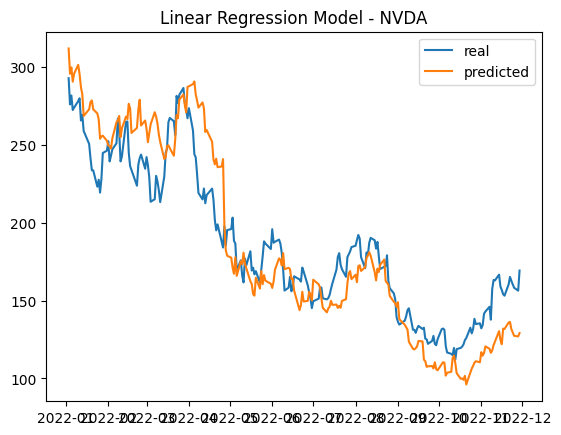

In [73]:
plt.plot(y_test_NVDA, label = 'real')
plt.plot(lrm_pred_NVDA, label = 'predicted')
plt.title("Linear Regression Model - NVDA")
plt.ylabel('')
plt.legend()
plt.show()

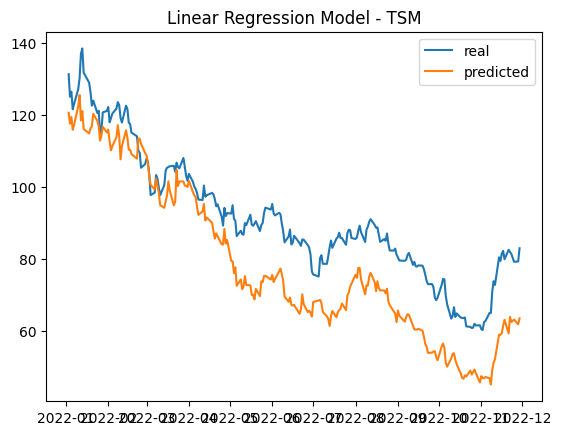

In [74]:
plt.plot(y_test_TSM, label = 'real')
plt.plot(lrm_pred_TSM, label = 'predicted')
plt.title("Linear Regression Model - TSM")
plt.ylabel('')
plt.legend()
plt.show()

# Time Series Model

In [75]:
!pip install statsmodels

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [76]:
#Time Series Model

# testing with the AR(1) model
"""
import statsmodels.formula.api as smf

combined['NVDA_close_week_prior'] = combined['NVDA close'].shift(7)

combined['TSM_close_week_prior'] = combined['TSM close'].shift(7)

NVDA_elim = combined['NVDA_close_week_prior'].tail(combined.shape[0] - 7)

TSM_elim = combined['TSM_close_week_prior'].tail(combined.shape[0] - 7)

X_train_NVDA_AR = sm.add_constant(NVDA_elim)
X_train_TSM_LR = sm.add_constant(TSM_elim)


# Fit the data to the model
lrm_model_NVDA = sm.OLS(y_train_NVDA, X_train_NVDA_AR).fit() #ordinary least square
print(lrm_model_NVDA.summary())


lrm_model_TSM = sm.OLS(y_train_TSM, X_train_TSM_AR).fit() #ordinary least square
print(lrm_model_TSM.summary())

**/
"""

"\nimport statsmodels.formula.api as smf\n\ncombined['NVDA_close_week_prior'] = combined['NVDA close'].shift(7)\n\ncombined['TSM_close_week_prior'] = combined['TSM close'].shift(7)\n\nNVDA_elim = combined['NVDA_close_week_prior'].tail(combined.shape[0] - 7)\n\nTSM_elim = combined['TSM_close_week_prior'].tail(combined.shape[0] - 7)\n\nX_train_NVDA_AR = sm.add_constant(NVDA_elim)\nX_train_TSM_LR = sm.add_constant(TSM_elim)\n\n\n# Fit the data to the model\nlrm_model_NVDA = sm.OLS(y_train_NVDA, X_train_NVDA_AR).fit() #ordinary least square\nprint(lrm_model_NVDA.summary())\n\n\nlrm_model_TSM = sm.OLS(y_train_TSM, X_train_TSM_AR).fit() #ordinary least square\nprint(lrm_model_TSM.summary())\n\n**/\n"

In [77]:
import matplotlib.pyplot as plt

def plot_entire_series(x, y, **kwargs):
    
    plt.figure(figsize=(16, 4))
    plt.plot(x, y, linewidth=2, color='black')
    
    for key, value in kwargs.items():
        plt.plot(x, value, linewidth=2, color=key)
        
        
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Sales', fontsize=16)
    plt.show()
    
    return None

In [79]:
x = combined['Date'].to_numpy()

y = combined['NVDA close'].to_numpy()

y_pred = combined['NVDA_close_week_prior'].to_numpy()

plot_entire_series(x, y, red=y_pred)

KeyError: 'NVDA_close_week_prior'

In [80]:
"""
ar1 = smf.ols(formula='NVDA close ~ NVDA_close_week_prior', data=combined).fit()
print(ar1.summary())
"""

"\nar1 = smf.ols(formula='NVDA close ~ NVDA_close_week_prior', data=combined).fit()\nprint(ar1.summary())\n"

# Neural-Network

In [81]:
nm1_NVDA = Sequential()
nm1_NVDA.add(Dense(33, activation='relu', input_dim=X_train_NVDA.shape[1]))
nm1_NVDA.add(Dense(16, activation='relu'))
nm1_NVDA.add(Dense(1))

# compile the model
nm1_NVDA.compile(optimizer='adam', loss='mean_squared_error')

nm1_NVDA.fit(X_train_NVDA, y_train_NVDA, epochs = 50)

Epoch 1/50
2022-12-16 19:49:07.262195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-16 19:49:07.262234: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-16 19:49:07.262253: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-d2ded45b-30e4-4539-81bb-350c682041f4): /proc/driver/nvidia/version does not exist
2022-12-16 19:49:07.262586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
31/31 [==============================] - 0s 1ms/step - loss: 2652

In [82]:
nm1_TSM = Sequential()
nm1_TSM.add(Dense(30, activation='relu', input_dim=X_train_TSM.shape[1]))
nm1_TSM.add(Dense(15, activation='relu'))
nm1_TSM.add(Dense(1))

# compile the model
nm1_TSM.compile(optimizer='adam', loss='mean_squared_error')

nm1_TSM.fit(X_train_TSM, y_train_TSM, epochs = 50)

Epoch 1/50
31/31 [==============================] - 0s 1ms/step - loss: 234086.2188
Epoch 2/50
31/31 [==============================] - 0s 2ms/step - loss: 9291.5469
Epoch 3/50
31/31 [==============================] - 0s 3ms/step - loss: 1928.6230
Epoch 4/50
31/31 [==============================] - 0s 1ms/step - loss: 971.8458
Epoch 5/50
31/31 [==============================] - 0s 1ms/step - loss: 508.3376
Epoch 6/50
31/31 [==============================] - 0s 3ms/step - loss: 351.7135
Epoch 7/50
31/31 [==============================] - 0s 2ms/step - loss: 261.1211
Epoch 8/50
31/31 [==============================] - 0s 1ms/step - loss: 212.8964
Epoch 9/50
31/31 [==============================] - 0s 3ms/step - loss: 177.0457
Epoch 10/50
31/31 [==============================] - 0s 3ms/step - loss: 160.0354
Epoch 11/50
31/31 [==============================] - 0s 1ms/step - loss: 146.6977
Epoch 12/50
31/31 [==============================] - 0s 3ms/step - loss: 141.9013
Epoch 13/50
31/31 [=

In [79]:
nm1_pred_NVDA = nm1_NVDA.predict(X_test_NVDA)
nm1_pred_TSM = nm1_TSM.predict(X_test_TSM)
print(OSR2(y_train_NVDA, y_test_NVDA, nm1_pred_NVDA.flatten()))
print(OSR2(y_train_TSM, y_test_TSM, nm1_pred_TSM.flatten()))

8/8 [==============================] - 0s 1ms/step
0.8948833619789859
0.47205238833656593


In [83]:
nm2_NVDA = Sequential()
nm2_NVDA.add(Dense(23, activation='relu', input_dim=X_train_NVDA.shape[1]))
nm2_NVDA.add(Dense(10, activation='relu'))
nm2_NVDA.add(Dense(10, activation='relu'))
nm2_NVDA.add(Dense(10, activation='relu'))
nm2_NVDA.add(Dense(10, activation='relu'))
nm2_NVDA.add(Dense(1))

# compile the model
nm2_NVDA.compile(optimizer='adam', loss='mean_squared_error')

nm2_NVDA.fit(X_train_NVDA, y_train_NVDA, epochs = 100)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 1135677.6250
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 31824.1816
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 5729.5947
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 4566.7944
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 3759.5488
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 3057.2246
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 2495.5615
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 2113.9971
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 1898.5411
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 1780.4949
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 1705.6768
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 1656.39

In [84]:
nm2_NVDA_pred= nm2_NVDA.predict(X_test_NVDA)
print(OSR2(y_train_NVDA, y_test_NVDA, nm2_NVDA_pred.flatten()))

8/8 [==============================] - 0s 1ms/step
0.7826462456973052


In [85]:
NVDA_nm_PER,NVDA_nm_ALPER, NVDA_nm_RATIO = stocktradesimulator(y_test_NVDA, nm2_NVDA_pred)

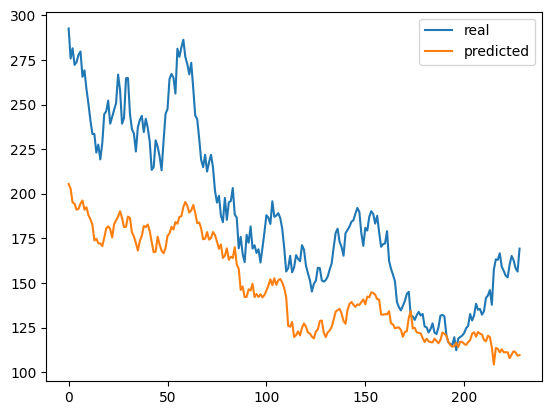

In [86]:
real = y_test_NVDA.reset_index().drop(columns = 'DateTime')
plt.plot(real, label = 'real')
plt.plot(nm2_NVDA_pred.flatten(), label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

In [87]:
nm2_TSM = Sequential()
nm2_TSM.add(Dense(23, activation='relu', input_dim=X_train_TSM.shape[1]))
nm2_TSM.add(Dense(10, activation='relu'))
nm2_TSM.add(Dense(10, activation='relu'))
nm2_TSM.add(Dense(10, activation='relu'))
nm2_TSM.add(Dense(10, activation='relu'))
nm2_TSM.add(Dense(1))

# compile the model
nm2_TSM.compile(optimizer='adam', loss='mean_squared_error')

nm2_TSM.fit(X_train_TSM, y_train_TSM, epochs = 100)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 261485.1250
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 2536.9963
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 714.0408
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 280.2933
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 152.6282
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 124.6815
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 115.8045
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 107.2051
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 93.6755
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 87.2929
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 83.6231
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 77.3302
Epoch 13/100


In [88]:
nm2_TSM_pred= nm2_TSM.predict(X_test_TSM)
print(OSR2(y_train_TSM, y_test_TSM, nm2_TSM_pred.flatten()))

8/8 [==============================] - 0s 1ms/step
0.8958572920444996


In [89]:
TSM_nm_PER,TSM_nm_ALPER, TSM_nm_RATIO = stocktradesimulator(y_test_TSM, nm2_TSM_pred)

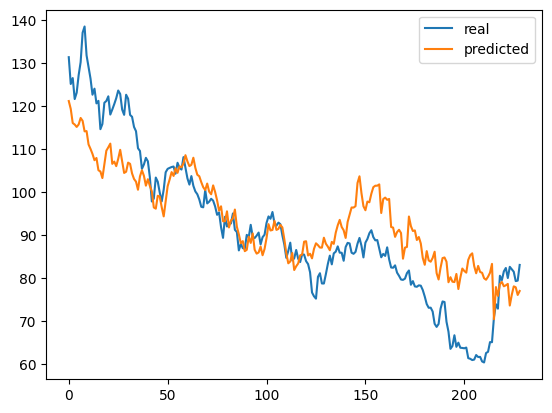

In [90]:
real_2 = y_test_TSM.reset_index().drop(columns = 'DateTime')
plt.plot(real_2, label = 'real')
plt.plot(nm2_TSM_pred.flatten(), label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

In [91]:
NVDA_nm_R2 = round(r2_score(y_train_NVDA, nm2_NVDA.predict(X_train_NVDA).flatten()),5)
TSM_nm_R2 = round(r2_score(y_train_TSM, nm2_TSM.predict(X_train_TSM).flatten()),5)
NVDA_nm_OSR2 = round(OSR2(y_train_NVDA, y_test_NVDA, nm2_NVDA_pred.flatten()),5)
TSM_nm_OSR2 =round(OSR2(y_train_TSM, y_test_TSM, nm2_TSM_pred.flatten()),5)

31/31 [==============================] - 0s 1ms/step


# Comparison Table

In [92]:
comparison_data = {'Baseline(NVDA)':[NVDA_base_R2,NVDA_base_OSR2],
                    'Baseline(TSM)':[TSM_base_R2,TSM_base_OSR2],
                    'Random Forest(NVDA)':[NVDA_r2,NVDA_OSR2],
                   'Random Forest(TSM)':[TSM_r2,TSM_OSR2],
                   'CART Regression(NVDA)':[NVDA_cart_r2,NVDA_cart_OSR2],
                   'CART Regression(TSM)':[TSM_cart_r2,TSM_cart_OSR2],
                   'linear Regression(NVDA)':[NVDA_LR_R2,NVDA_LR_OSR2],
                   'linear Regression(TSM)':[TSM_LR_R2,TSM_LR_OSR2],
                   'Neural-Network(NVDA)':[NVDA_nm_R2,NVDA_nm_OSR2],
                   'Neural-Network(TSM)':[TSM_nm_R2,TSM_nm_OSR2]}

comparison_table = pd.DataFrame(data=comparison_data, index=['R2', 'OSR2']).transpose()
comparison_table.style.set_properties(**{'font-size': '12pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])
comparison_table

,R2,OSR2
Baseline(NVDA),0.98190,0.83759
Baseline(TSM),0.98261,0.90011
Random Forest(NVDA),0.99621,0.95469
Random Forest(TSM),0.99690,0.77893
CART Regression(NVDA),0.99255,0.86191
CART Regression(TSM),0.99431,0.70597
linear Regression(NVDA),0.98957,0.94565
linear Regression(TSM),0.99153,0.79499
Neural-Network(NVDA),0.81751,0.78265
Neural-Network(TSM),0.95516,0.89586


In [93]:
stocktradesimulator_data = {'Random Forest(NVDA)':[NVDA_RF_PER,NVDA_RF_ALPER, NVDA_RF_RATIO],
                   'Random Forest(TSM)':[TSM_RF_PER,TSM_RF_ALPER, TSM_RF_RATIO],
                   'CART Regression(NVDA)':[NVDA_cart_PER, NVDA_cart_ALPER, NVSA_cart_RATIO],
                   'CART Regression(TSM)':[TSM_cart_PER,TSM_cart_ALPER, TSM_cart_RATIO],
                   'linear Regression(NVDA)':[NVDA_LR_PER,NVDA_LR_ALPER, NVDA_LR_RATIO],
                   'linear Regression(TSM)':[TSM_LR_PER,TSM_LR_ALPER, TSM_LR_RATIO],
                   'Neural-Network(NVDA)':[NVDA_nm_PER,NVDA_nm_ALPER, NVDA_nm_RATIO],
                   'Neural-Network(TSM)':[TSM_nm_PER,TSM_nm_ALPER, TSM_nm_RATIO],}


stocktradesimulator_table = pd.DataFrame(data=stocktradesimulator_data, index=['actual performance', 'algo performance', 'ratio']).transpose()
stocktradesimulator_table.style.set_properties(**{'font-size': '12pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])
stocktradesimulator_table

,actual performance,algo performance,ratio
Random Forest(NVDA),0.57831,0.67611,0.16910
Random Forest(TSM),0.63188,0.69359,0.09765
CART Regression(NVDA),0.57831,1.15277,0.99334
CART Regression(TSM),0.63188,0.68373,0.08205
linear Regression(NVDA),0.57831,1.11918,0.93525
linear Regression(TSM),0.63188,1.12762,0.78454
Neural-Network(NVDA),0.57831,1.05888,0.83097
Neural-Network(TSM),0.63188,0.83571,0.32257


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d2ded45b-30e4-4539-81bb-350c682041f4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>